# QSVM on MNIST

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

from utils import * 

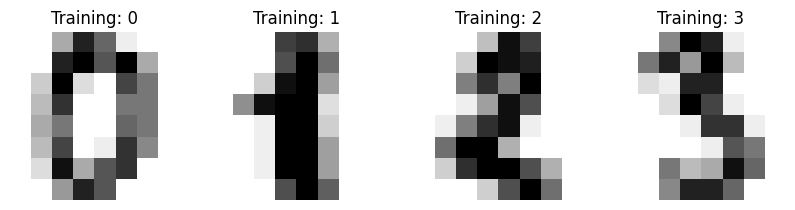

In [2]:
%matplotlib inline
digits = datasets.load_digits()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training: {label}")

plt.show()

In [3]:
print(len(digits.images))

1797


In [4]:
X = digits.data       # features
y = digits.target     # labels

In [5]:
# Filter the data to include only digits '0' and '1'
zero_one_indices = (y == 0) | (y == 1)
X = X[zero_one_indices]
y = y[zero_one_indices]

y = np.where(y == 0, -1, 1)

print("Shape of data for digits 0 and 1:", X.shape)
print("Shape of target for digits 0 and 1:", y.shape)

Shape of data for digits 0 and 1: (360, 64)
Shape of target for digits 0 and 1: (360,)


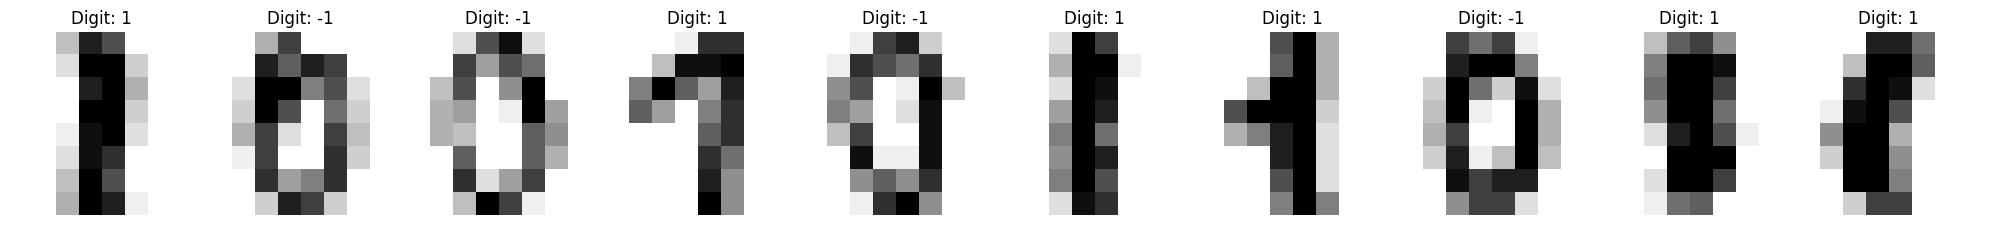

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Select a few random indices to display
num_display = 10
random_indices = np.random.choice(len(X), num_display, replace=False)

# Display the images
plt.figure(figsize=(num_display * 2, 4))
for i, index in enumerate(random_indices):
    plt.subplot(1, num_display, i + 1)
    # Reshape the image to 8x8
    image = X[index].reshape(8, 8)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.title(f"Digit: {y[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [8]:
import os

def write_samples(X, Y, path): 
    import os
    os.makedirs(os.path.dirname(path), exist_ok=True)

    with open(path, "w") as f: 
        f.write("id label data\n") 
        for i in range(X.shape[0]):
            features = " ".join(str(val) for val in X[i])   # no brackets, no commas
            f.write(f"{i} {Y[i]} {features}\n")

In [9]:
from sklearn import preprocessing

# 10-fold Monte Carlo (or split-and-shuffle) cross-validation
fold=10

id_dataset = "mnist"
for i in range(0,fold):
    X_train_cal, X_val_cal, Y_train_cal, Y_val_cal = train_test_split(X_train,y_train, test_size=0.5, random_state=i, stratify=y_train)
    
    # Pre-processing 
    X_train_cal = preprocessing.scale(X_train_cal)
    X_val_cal = preprocessing.scale(X_val_cal)
        
    # Write the data
    write_samples(X_train_cal, Y_train_cal,'input_datasets/calibration3/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i))
    write_samples(X_val_cal, Y_val_cal,'input_datasets/calibration3/'+id_dataset+'/'+id_dataset+'calibval'+str(i))
    
print('Each training set includes '+str(X_train_cal.shape[0])+ ' samples')
print('Each validation set includes '+str(X_val_cal.shape[0])+ ' samples')

Each training set includes 162 samples
Each validation set includes 162 samples


## Calibration

In [ ]:
from quantum_SVM import *

# Hyperparameters 
B=[2]
K=[3]
xi=[1]
gamma=[1]
n_experiments=len(B)*len(K)*len(xi)*len(gamma)

hyperparameters=np.zeros([n_experiments,4], dtype=float)

path_data_key='input_datasets/calibration3/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/calibration3/'+id_dataset+'/'

trainacc=np.zeros([fold], dtype=float)
trainauroc=np.zeros([fold], dtype=float)
trainauprc=np.zeros([fold], dtype=float)
    
testacc=np.zeros([fold], dtype=float)
testauroc=np.zeros([fold], dtype=float)
testauprc=np.zeros([fold], dtype=float)

trainacc_all=np.zeros([n_experiments], dtype=float)
trainauroc_all=np.zeros([n_experiments], dtype=float)
trainauprc_all=np.zeros([n_experiments], dtype=float)
    
testacc_all=np.zeros([n_experiments], dtype=float)
testauroc_all=np.zeros([n_experiments], dtype=float)
testauprc_all=np.zeros([n_experiments], dtype=float)


f = open(path_out+'calibration_results.txt',"w") 
f.write("B\t K\t xi\t   gamma\t trainacc\t trainauroc\t trainauprc\t testacc\t testauroc\t testauprc\n") 
  
count=0 
for x in range(0,len(B)):
    for y in range(0,len(K)):
        for z in range(0,len(xi)):
            for i in range(0,len(gamma)):
                for j in range(0,fold):
                    path=gen_svm_qubos(B[x],K[y],xi[z],gamma[i],path_data_key,data_key+str(j),path_out)
                    pathsub=dwave_run(path_data_key,path)
                    [trainacc[j],trainauroc[j],trainauprc[j],testacc[j],testauroc[j],testauprc[j]]=eval_run_rocpr_curves(path_data_key,pathsub,'noplotsave')
                    
                hyperparameters[count,0]=B[x]
                hyperparameters[count,1]=K[y]
                hyperparameters[count,2]=xi[z]
                hyperparameters[count,3]=gamma[i]
            
                trainacc_all[count]=np.average(trainacc)
                trainauroc_all[count]=np.average(trainauroc)
                trainauprc_all[count]=np.average(trainauprc)
    
                testacc_all[count]=np.average(testacc)
                testauroc_all[count]=np.average(testauroc)
                testauprc_all[count]=np.average(testauprc)
                
                np.save(path_out+'hyperparameters', hyperparameters)
                np.save(path_out+'trainacc_all', trainacc_all)
                np.save(path_out+'trainauroc_all', trainauroc_all)
                np.save(path_out+'trainauprc_all', trainauprc_all)
                np.save(path_out+'testacc_all', testacc_all)
                np.save(path_out+'testauroc_all', testauroc_all)
                np.save(path_out+'testauprc_all', testauprc_all)
                
                f.write(f'{B[x]}\t {K[y]}\t {xi[z]}\t {gamma[i]:8.3f}\t {np.average(trainacc):8.4f}\t {np.average(trainauroc):8.4f}\t {np.average(trainauprc):8.4f}\t {np.average(testacc):8.4f}\t {np.average(testauroc):8.4f}\t {np.average(testauprc):8.4f}')
                f.write("\n") 
                count=count+1
                
f.close() 

[gen_svm_qubos] mnistcalibtrain0 unique labels: [-1.  1.]
Creating the QUBO of size (486, 486)
Extracting nodes and couplers
Saving 486 nodes and 117855 couplers for outputs/calibration3/mnist/runmnistcalibtrain0_B=2_K=3_xi=1_gamma=1/
running outputs/calibration3/mnist/runmnistcalibtrain0_B=2_K=3_xi=1_gamma=1/result_couplers=117855/ with 486 nodes and 117855 couplers
 -- no embedding found, removing outputs/calibration3/mnist/runmnistcalibtrain0_B=2_K=3_xi=1_gamma=1/result_couplers=117855/ and trying fewer couplers
running outputs/calibration3/mnist/runmnistcalibtrain0_B=2_K=3_xi=1_gamma=1/result_couplers=2500/ with 486 nodes and 2500 couplers
idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc
0	 -9.0000	  0.8086	  1.0000	  1.0000	  0.5062	  0.9994	  0.9994
0	 -9.0000	  0.8086	  1.0000	  1.0000	  0.5062	  0.9994	  0.9994
1	 -5.0000	  0.7901	  1.0000	  1.0000	  0.5000	  0.9992	  0.9993
1	 -5.0000	  0.7901	  1.0000	  1.0000	  0.5000	  0.9992	  0.9993
2	 -6.0000	

In [49]:
import importlib, utils, quantum_SVM
importlib.reload(utils)
importlib.reload(quantum_SVM)
from quantum_SVM import *

### Training

In [19]:
from quantum_SVM import *
import numpy as np
from utils import *
from sklearn.model_selection import KFold
from sklearn import preprocessing

# Write the data
experiments=1
slice=40 # Number of samples to use for the training
fold=int(len(X_train)/40)

print(fold)

for i in range(0,experiments):    
    cv = KFold(n_splits=fold, random_state=i, shuffle=True)
    count=0
    for test_index, train_index in cv.split(X_train):
        #print("Train Index: ", len(train_index), "\n")
        
        X_train_slice, y_train_slice = X_train[train_index], y_train[train_index]
        X_train_slice = preprocessing.scale(X_train_slice)
        
        X_test_slice, y_test_slice = X_train[test_index], y_train[test_index]
        X_test_slice = preprocessing.scale(X_test_slice)
        
        write_samples(X_train_slice, y_train_slice,f'input_datasets/train/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i)+'_'+str(count))
        write_samples(X_test_slice, y_test_slice,f'input_datasets/train/'+id_dataset+'/'+id_dataset+'calibval'+str(i)+'_'+str(count))
        
        count=count+1

print("Each training set has", len(train_index), "samples\n")

8
Each training set has 40 samples



In [20]:
# Get the calibration results
path_out='outputs/calibration/'+id_dataset+'/'
hyperparameters=np.load(path_out+'hyperparameters.npy')
testauprc_all=np.load(path_out+'testauprc_all.npy')

# Select the best hyperparameter set for the max value of testauprc
idx_max = np.where(testauprc_all == np.amax(testauprc_all))
B=int(hyperparameters[int(idx_max[0]),0])
K=int(hyperparameters[int(idx_max[0]),1])
xi=int(hyperparameters[int(idx_max[0]),2])
gamma=hyperparameters[int(idx_max[0]),3]
print('The best hyperparameters are:\n'+'B = '+str(B)+' K = '+str(K)+' xi = '+str(xi)+' gamma = '+str(gamma))

path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/train/'+id_dataset+'/'

trained_SVMs=[]

for j in range(0,experiments):
    for i in range(0,fold):
        path=gen_svm_qubos(B,K,xi,gamma,path_data_key,data_key+str(j)+'_'+str(i),path_out)
        trained_SVMs.append(dwave_run(path_data_key,path))
        np.save(path_out+'trained_SVMs',trained_SVMs)   

/tmp/ipykernel_260/3094108616.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B=int(hyperparameters[int(idx_max[0]),0])
/tmp/ipykernel_260/3094108616.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K=int(hyperparameters[int(idx_max[0]),1])
/tmp/ipykernel_260/3094108616.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi=int(hyperparameters[int(idx_max[0]),2])
/tmp/ipykernel_260/3094108616.py:11: DeprecationWarning: Conversion of an array with ndim > 0 t

The best hyperparameters are:
B = 2 K = 2 xi = 0 gamma = 0.5
[gen_svm_qubos] mnistcalibtrain0_0 unique labels: [1.]
Creating the QUBO of size (82, 82)
Extracting nodes and couplers
Saving 82 nodes and 707 couplers for outputs/train/mnist/runmnistcalibtrain0_0_B=2_K=2_xi=0_gamma=0.5/
running outputs/train/mnist/runmnistcalibtrain0_0_B=2_K=2_xi=0_gamma=0.5/result_couplers=707/ with 82 nodes and 707 couplers
[gen_svm_qubos] mnistcalibtrain0_1 unique labels: [1.]
Creating the QUBO of size (82, 82)
Extracting nodes and couplers
Saving 82 nodes and 515 couplers for outputs/train/mnist/runmnistcalibtrain0_1_B=2_K=2_xi=0_gamma=0.5/
running outputs/train/mnist/runmnistcalibtrain0_1_B=2_K=2_xi=0_gamma=0.5/result_couplers=515/ with 82 nodes and 515 couplers
[gen_svm_qubos] mnistcalibtrain0_2 unique labels: [1.]
Creating the QUBO of size (82, 82)
Extracting nodes and couplers
Saving 82 nodes and 500 couplers for outputs/train/mnist/runmnistcalibtrain0_2_B=2_K=2_xi=0_gamma=0.5/
running outputs/trai

In [18]:
from quantum_SVM import *
import numpy as np
from utils import *

# input calibration data
path_data_key = 'input_datasets/train/' + id_dataset + '/'
data_key = id_dataset + 'calibtrain'

# run folder (where alphas are stored)
path_in = 'outputs/train/mnist/runmnistcalibtrain0_4_B=2_K=2_xi=0_gamma=0.5/result_couplers=397'

trainacc[j], trainauroc[j], trainauprc[j], \
testacc[j], testauroc[j], testauprc[j] = eval_run_rocpr_curves(
    path_data_key,
    path_in,
    'saveplot'
)

idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## Test

In [56]:
from quantum_SVM import *
from sklearn import preprocessing

# Pre-processing the test spectra
X_test = preprocessing.scale(X_test)

path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_train_out='outputs/train/'+id_dataset+'/'
path_test_out='outputs/test/'+id_dataset+'/'

path_files=np.load(path_train_out+'trained_SVMs.npy')

experiments=1
slices = len(path_files)
scores=[]

for j in range(0,experiments):
    for i in range(0,slices):
        scores.append(predict(path_data_key,path_files[i],X_test))
 
 
avg_scores=np.zeros((scores[0].shape[0]))
Y_predicted=np.zeros((scores[0].shape[0]),int)

for i in range(0,scores[0].shape[0]):
    tmp=0
    for y in range(0,slices):
        tmp=tmp+scores[y][i]
    avg_scores[i]=tmp/slices   
 
for i in range(0,scores[0].shape[0]):
    if(avg_scores[i]<0):
        Y_predicted[i]=1
    else:
        Y_predicted[i]=2
        

datawrite(path_test_out,'qeSVM', 'mnist', Y_predicted)

True